# Customer Segmentation

The data set used in this project is from the UCI Machine Learning Repository and it's a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
https://archive.ics.uci.edu/dataset/352/online+retail

In [2]:
import datetime
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

We will set a Random Seed for reproducibility.

In [3]:
RANDOM_SEED = 1234

Let's load the data set and take a look at the first rows.

In [4]:
df = pd.read_excel('Online Retail.xlsx')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


It's a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

Firs of all we will cast to correct data types and remove the rows with missing values.

In [5]:
df = df.astype({
    'InvoiceNo': 'str',
    'StockCode': 'str',
    'Description': 'str',
    'Quantity': 'int32',
    'InvoiceDate': 'datetime64[ns]',
    'UnitPrice': 'float32',
    'CustomerID': 'str',
    'Country': 'str'
    }, copy=True)

In [6]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

No missing values were found.

In [7]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

No null values were found.

In [8]:
df.shape

(541909, 8)

As indicated in the description of the data set, there are some transactions with negative values in the Quantity column. We will remove those rows. Also we will remove the rows with negative values in the UnitPrice column and InvoiceNo starting with C which are credit transactions.

Dropping rows with `InvoiceNo` starting with "C" as they are credit orders.

In [9]:
df[df['Description'] == 'PAPER CRAFT , LITTLE BIRDIE']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


In [10]:
df = df[~df['InvoiceNo'].str.startswith('C', na=False)] # removed credit transactions

Same with `POSTAGE` since they are mailing expenditures.

In [11]:
df = df[~df['Description'].str.contains('POSTAGE')]

Unfortunatelly there are some `CustomerID` missing, so we will drop them.

In [12]:
df = df[df['CustomerID'] != 'nan']

Then we check if the Quantity is negative, and if so, we drop them as well.

In [13]:
df[df['Quantity'] <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [14]:
df['Amount'] = df['Quantity'] * df['UnitPrice']

We also wanto to drop the rows with `UnitPrice` equal to 0. We can just drop the `Amount` equal to 0, since it is the product of `Quantity` and `UnitPrice`.

In [15]:
df = df[df['Amount'] != 0]

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.300000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.340001
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.340001
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.340001


## Data Aggregation

Let's create a new data frame with the total amount spent by each customer. We want a data frame with the `CustomerID` as index and the features we will use for the clustering.

We will group by `CustomerID` and get the number of unique `InvoiceNo` that each customer has.

In [17]:
df_freq = df.groupby('CustomerID')['InvoiceNo'].nunique(
).reset_index().rename(columns={'InvoiceNo': 'Freq'})
df_freq.head()

,CustomerID,Freq
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


Then we want the total amount spent by each customer.

In [18]:
df_amount = df.groupby(['CustomerID'])['Amount'].sum().reset_index().rename(columns={'Amount': 'TotalAmount'})
df_amount.head()

,CustomerID,TotalAmount
0,12346.0,77183.597169
1,12347.0,4309.999988
2,12348.0,1437.239997
3,12349.0,1457.549994
4,12350.0,294.399997


And also it could be interesting to know the average number of unique items per order.

In [19]:
df_mean_unique_items = df.groupby(['CustomerID', 'InvoiceNo'])['StockCode'].count().reset_index().groupby('CustomerID')['StockCode'].mean().reset_index().rename(columns={'StockCode': 'AvgUniqueItems'})
df_mean_unique_items.head()

,CustomerID,AvgUniqueItems
0,12346.0,1.00
1,12347.0,26.00
2,12348.0,6.75
3,12349.0,72.00
4,12350.0,16.00


Then we add a `Recency` column with the number of days since the last order. We will use the date of the last order in the data set as reference.

In [20]:
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)
df_recency = df.groupby('CustomerID')['InvoiceDate'].apply(lambda x: (snapshot_date - x.max()).days).rename('Recency').reset_index()
df_recency.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,2
2,12348.0,75
3,12349.0,19
4,12350.0,310


Let's merge all the data frames into one with the features we will use for the clustering.

In [21]:
customer_df = df_amount.merge(df_freq, on='CustomerID', how='inner').merge(df_mean_unique_items, on='CustomerID').merge(df_recency, on='CustomerID').set_index('CustomerID')
customer_df.head()

,TotalAmount,Freq,AvgUniqueItems,Recency
CustomerID,,,,
12346.0,77183.597169,1,1.00,326
12347.0,4309.999988,7,26.00,2
12348.0,1437.239997,4,6.75,75
12349.0,1457.549994,1,72.00,19
12350.0,294.399997,1,16.00,310


## Normalization

It is important to normalize the data before clustering. We will use the StandardScaler from scikit-learn which will transform the data to have a mean of 0 and a standard deviation of 1.

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.set_output(transform='pandas')

scaled_df = scaler.fit_transform(customer_df)
scaled_df.head()

,TotalAmount,Freq,AvgUniqueItems,Recency
CustomerID,,,,
12346.0,8.404671,-0.424308,-1.041455,2.334210
12347.0,0.254591,0.356620,0.186713,-0.905615
12348.0,-0.066695,-0.033844,-0.758976,-0.175654
12349.0,-0.064423,-0.424308,2.446542,-0.735624
12350.0,-0.194508,-0.424308,-0.304554,2.174219


In [23]:
scaled_df.describe()

,TotalAmount,Freq,AvgUniqueItems,Recency
count,4.338000e+03,4.338000e+03,4.338000e+03,4.338000e+03
mean,-3.275900e-18,1.310360e-17,1.572432e-16,3.275900e-18
std,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00
min,-2.270140e-01,-4.243078e-01,-1.041455e+00,-9.156145e-01
25%,-1.931873e-01,-4.243078e-01,-6.320658e-01,-7.456236e-01
50%,-1.527113e-01,-2.941532e-01,-2.554276e-01,-4.156415e-01
75%,-4.350927e-02,9.631085e-02,2.972481e-01,5.018090e-01
max,3.099097e+01,2.664786e+01,1.363299e+01,2.814184e+00


as we can see, the data is now normalized with a mean of 0 and a standard deviation of 1.

Then we can make a pairplot to see the distribution of the features. We can see that the features are not normally distributed, but we will use them as they are (without transforming them).

>As an exercise, you can try to transform the features to make them normally distributed and see if the clustering improves. You can use the Box-Cox transformation, log transformation, square root transformation, cubic and higher order transformations, etc.

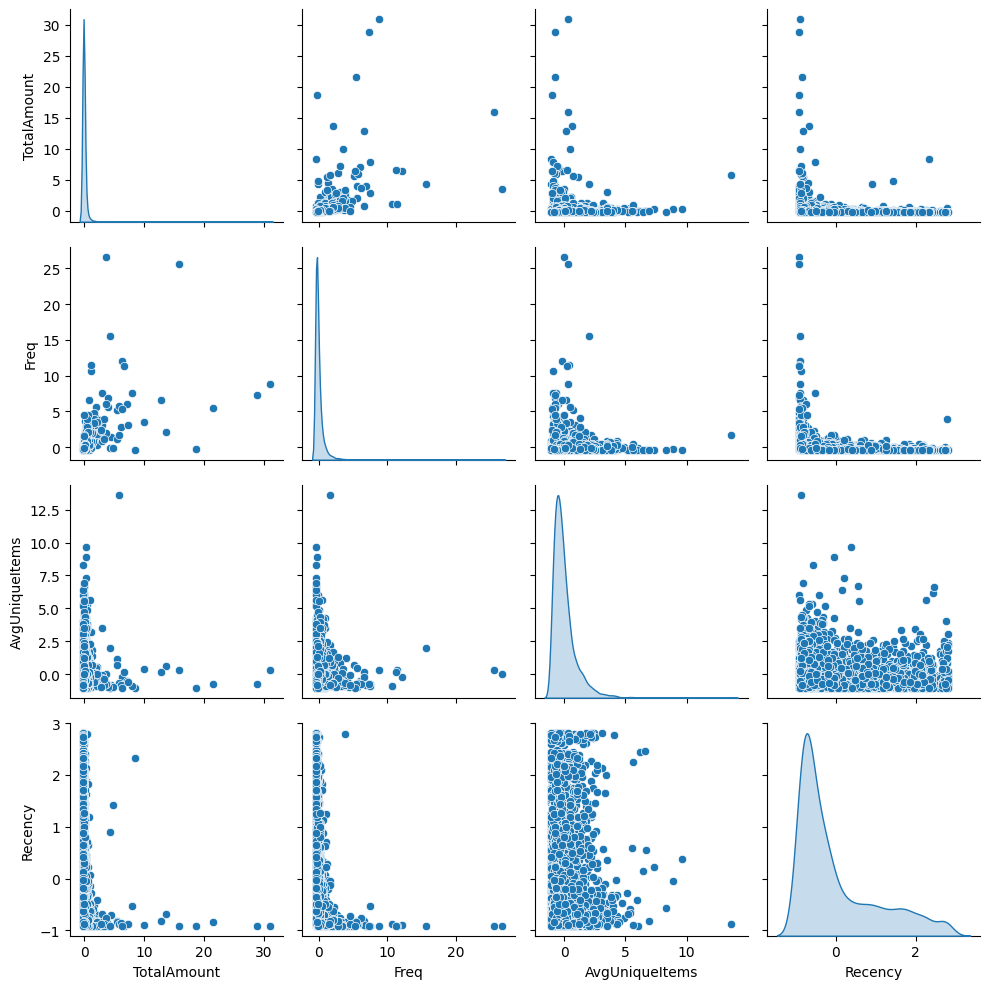

In [24]:
sns.pairplot(scaled_df, diag_kind='kde')
plt.tight_layout()
plt.show()

## PCA

In order to ensure that clusters are truly distinct we first perform a PCA with a number of components equal to the number of features. Then we plot the explained variance ratio for each component and select the number of components that explain most of the variance.
>Usually we select the number of components that explain 80% of the variance.

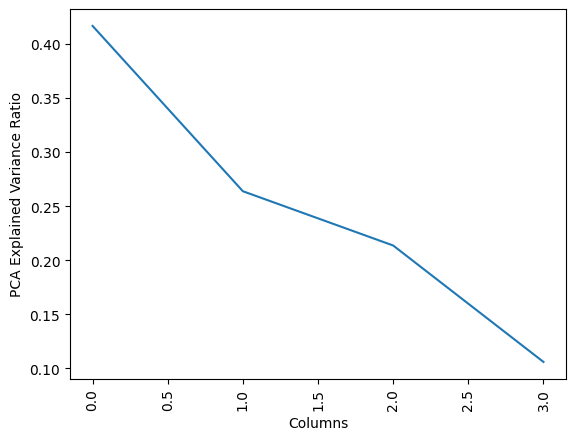

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=scaled_df.shape[1])

X_trans = pca.fit_transform(scaled_df)

# print(pca.explained_variance_ratio_ )

plt.plot(range(scaled_df.shape[1]), pca.explained_variance_ratio_)

plt.xlabel('Columns')
plt.ylabel('PCA Explained Variance Ratio')

plt.xticks(rotation=90)

plt.show()

In [28]:
THRESHOLD = 0.8

explained_variances = pca.explained_variance_ratio_

# Sort the explained variance ratios in descending order
sorted_variances = sorted(explained_variances, reverse=True)


# Calculate the cumulative sum of the explained variance ratios
cumulative_variances = np.cumsum(sorted_variances)

# Find the index i of the first principal component where the cumulative sum exceeds 0.8
cutoff_index = np.argmax(cumulative_variances >= THRESHOLD)
print("Used the top {} transformed variables".format(cutoff_index+1))

# Keep the first i principal components and discard the rest
X = pca.transform(scaled_df)[:, :cutoff_index+1]

Used the top 3 transformed variables


So we will use the first 3 components.
>Keep in mind that the components are not the same as the original features. They are linear combinations of the original features and so they are not directly interpretable.

In [30]:
X.shape

(4338, 3)

# K-Means

We can now perform the K-Means clustering. We will use the elbow method to select the number of clusters. We will use a plot with both the inertia and the silhouette score to select the number of clusters.

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

we will first make a search for the best number of clusters using both the inertia and the silhouette score and then select the number of clusters suitable for our problem.

In [32]:
estimators_kmeans = []
labels_kmeans = []
inertias = []
silhouette_scores = []

for k in range(2, 11):
    est = KMeans(n_clusters=k, n_init=50, random_state=RANDOM_SEED)
    est.fit(X)
    labels_kmeans.append(est.predict(X))
    estimators_kmeans.append(est)
    inertias.append(est.inertia_)
    silhouette_scores.append(silhouette_score(
        X, est.predict(X), random_state=RANDOM_SEED))

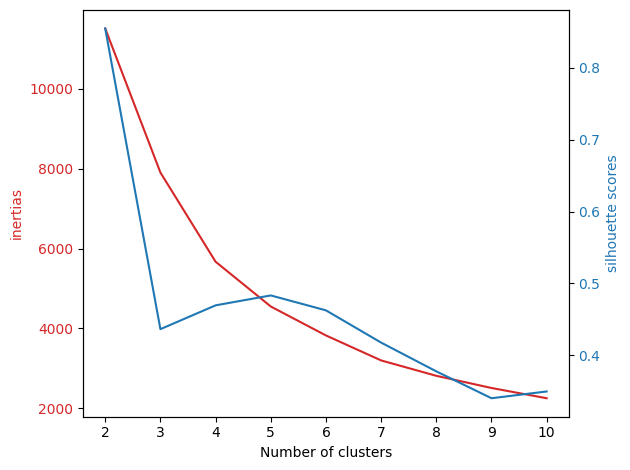

In [33]:
t = np.arange(2, 11)
data1 = inertias
data2 = silhouette_scores

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('inertias', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# we already handled the x-label with ax1
ax2.set_ylabel('silhouette scores', color=color)
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Here we can select two different numbers of clusters.

We can use 3 clusters (remember - simple is better) or 5 clusters (the number of clusters with the highest silhouette score).

We will try both of them and interpret the results.

### 3 Clusters

In [34]:
CLUSTERS = 3
num = CLUSTERS - 2

estimators_kmeans[num]

KMeans(n_clusters=3, n_init=50, random_state=1234)

In [35]:
print(
    f"Number of clusters = {estimators_kmeans[num].n_clusters} - Distortion = {inertias[num]:.2f} - Silhouette score = {silhouette_scores[num]:.2f}")

Number of clusters = 3 - Distortion = 7906.36 - Silhouette score = 0.44


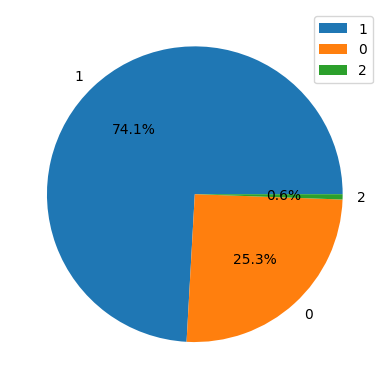

In [36]:
label_series = pd.Series(labels_kmeans[num])

plt.pie(label_series.value_counts(), autopct='%1.1f%%',
        labels=label_series.value_counts().index.tolist())
plt.legend(label_series.value_counts().index.tolist())
plt.show()

As we can see there is a big cluster with 2 smaller clusters (one representing only the 0.6% of the data set). Probably the 0.6% cluster is an outlier...

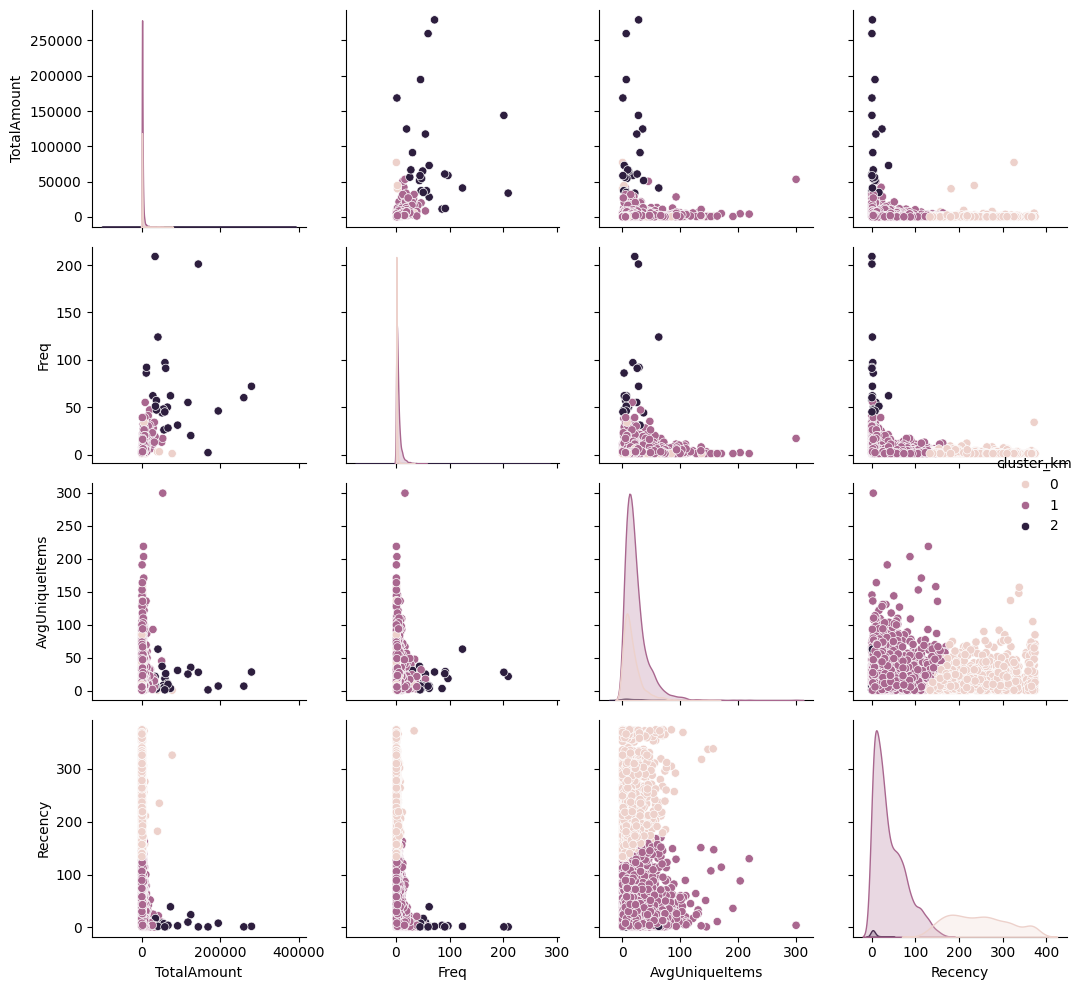

In [37]:
customer_df['cluster_km'] = labels_kmeans[num]
sns.pairplot(customer_df, hue='cluster_km')
plt.tight_layout()
plt.show()

The outliers are the customers with the highest amount spent, high frequency and low recency.

# Agglomerative Clustering

We can also try the Agglomerative Clustering algorithm. We will use the same number of clusters as in the K-Means algorithm. 
Keep in mind that the Agglomerative Clustering algorithm makes use of a distance matrix by means of the linkage function. We will use the Ward linkage function which minimizes the variance of the clusters being merged.

In [38]:
from sklearn.cluster import AgglomerativeClustering

In [39]:
estimators_agg = []
labels_agg = []
agg_df = pd.DataFrame(columns=['linkage', 'n_clusters', 'silhouette_score'])
i = 0

for k in np.arange(2, 5):
    for link in ['ward', 'complete', 'single', 'average']:
        est = AgglomerativeClustering(n_clusters=k, linkage=link)
        est.fit(X)
        labels = est.fit_predict(X)
        estimators_agg.append(est)
        labels_agg.append(labels)
        sh_score = silhouette_score(
            X, labels=est.labels_, random_state=1234)
        agg_df.loc[i] = [link, k, sh_score]
        i += 1

We sort the clusters by the silhouette score and select the number of clusters with the highest score still using 3 clusters as in the K-Means algorithm.

In [41]:
agg_df[agg_df.n_clusters >= 3].sort_values(by='silhouette_score', ascending=False).head()

,linkage,n_clusters,silhouette_score
7,average,3,0.869918
6,single,3,0.869128
10,single,4,0.868422
11,average,4,0.808782
9,complete,4,0.731265


In [42]:
agg_df[(agg_df.n_clusters == 3) & (agg_df.linkage == 'ward')]

,linkage,n_clusters,silhouette_score
4,ward,3,0.430855


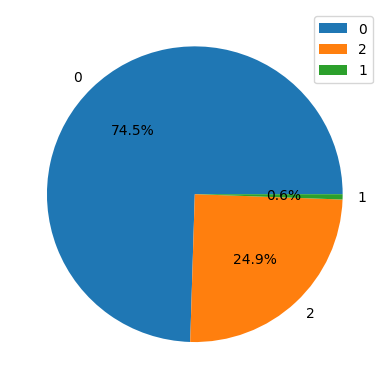

In [43]:
label_series = pd.Series(labels_agg[4])

plt.pie(label_series.value_counts(), autopct='%1.1f%%',
        labels=label_series.value_counts().index.tolist())
plt.legend(label_series.value_counts().index.tolist())
plt.show()

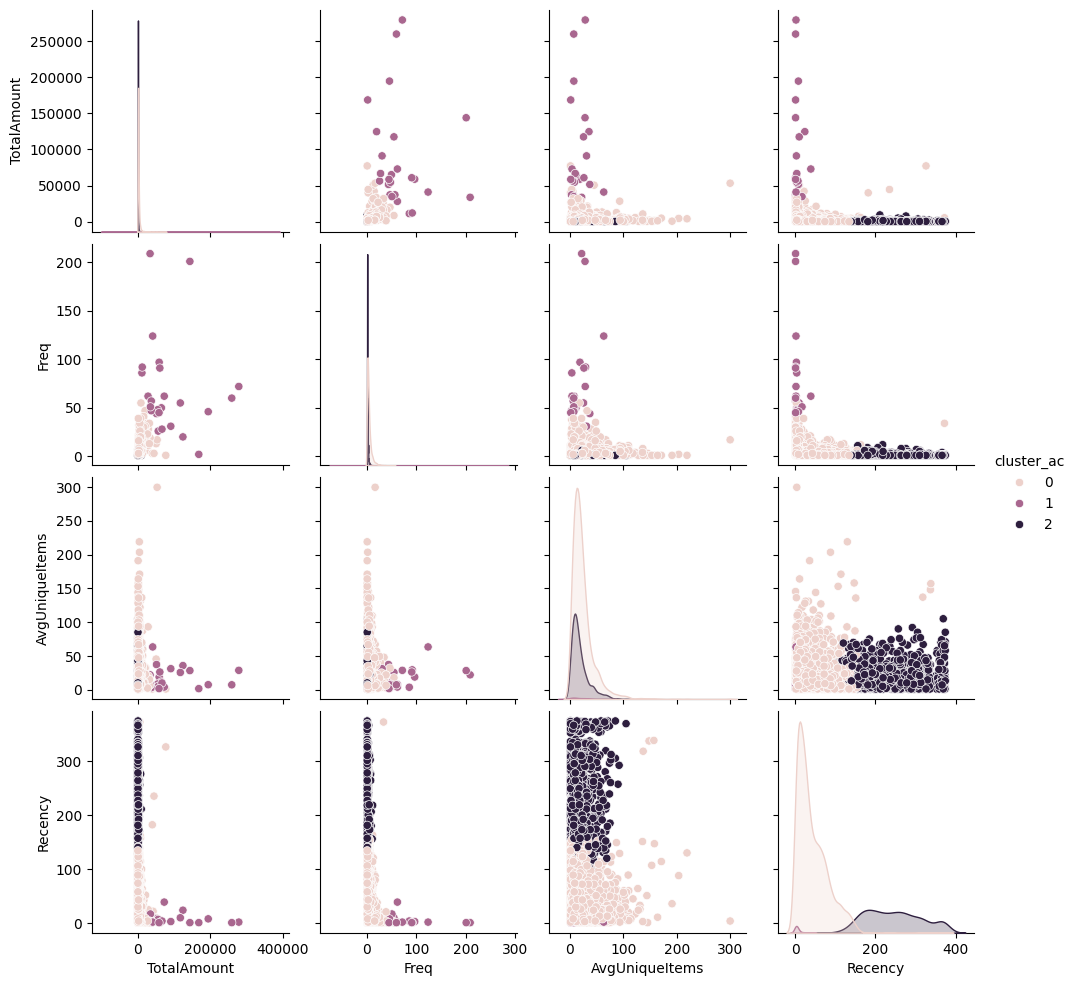

In [44]:
customer_df['cluster_ac'] = labels_agg[4]
sns.pairplot(customer_df.drop(columns='cluster_km'), hue='cluster_ac')
plt.show()

Almost the same results as in the K-Means algorithm. Cluster 1 has the highest amount spent, high frequency and low recency.

----
The solution with the Agglomerative Clustering in this case provides a result very similar to that of kmeans.

It is interesting to compare more deeply the results of the two clustering models.

The function `pair_confusion_matrix` computes the number of pairs of objects that are in the same clusters or in different clusters in two different clustering schemes.

The result is given in a 2x2 matrix, the smaller the numbers out of the main diagona, the better the match.

For easier readability, we divide all the elements of the matrix by the sum of all the elements of the matrix, in this way, the matrix elements are normalized to 1.

In [45]:
from sklearn.metrics import pair_confusion_matrix

total_sum = pair_confusion_matrix(
    customer_df['cluster_km'], customer_df['cluster_ac']).sum()
np.divide(pair_confusion_matrix(
    customer_df['cluster_km'], customer_df['cluster_ac']), total_sum)

array([[0.36131104, 0.02541301],
       [0.0215565 , 0.59171944]])

In [46]:
print(
    f"The percentage of match between the two clustering schemes is {np.diag(pair_confusion_matrix(customer_df['cluster_km'], customer_df['cluster_ac'])).sum()/total_sum * 100:.2f}%")

The percentage of match between the two clustering schemes is 95.30%


In [47]:
from matplotlib import cm

def plot_silhouette(silhouette_vals, y,
                    colors=cm.tab10,
                    plot_noise=False
                    ):
    """
    Plotting silhouette scores for the individual samples of a labelled data set.
    The scores will be grouped according to labels and sorted in descending order.
    The bars are proportional to the score and the color is determined by the label.
    
    silhouette_vals: the silhouette values of the samples
    y:               the labels of the samples
    plot_noise:      boolean, assumes the noise to be labeled with a negative integer
    
    """
    cluster_labels = np.unique(y)
    if not plot_noise:
        cluster_labels = cluster_labels[cluster_labels != -1]
    n_clusters = len(cluster_labels)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):  # generate pairs index, cluster_label
        # extracts records with the current cluster label
        c_silhouette_vals = silhouette_vals[y == c]
        c_silhouette_vals.sort()  # sort the silhouette vals for the current class
        y_ax_upper += len(c_silhouette_vals)
        color = colors(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                 edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        c_silhouette_avg = np.mean(c_silhouette_vals)
        plt.axvline(c_silhouette_avg, ymin=y_ax_lower/len(silhouette_vals), ymax=y_ax_upper/len(silhouette_vals), color=color, linestyle="-."
                    )
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="black", linestyle="--")
    plt.yticks(yticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient - Cluster means: -. Global mean: --')
    plt.tight_layout()
    # plt.savefig('./figures/silhouette.png', dpi=300)
    plt.show()

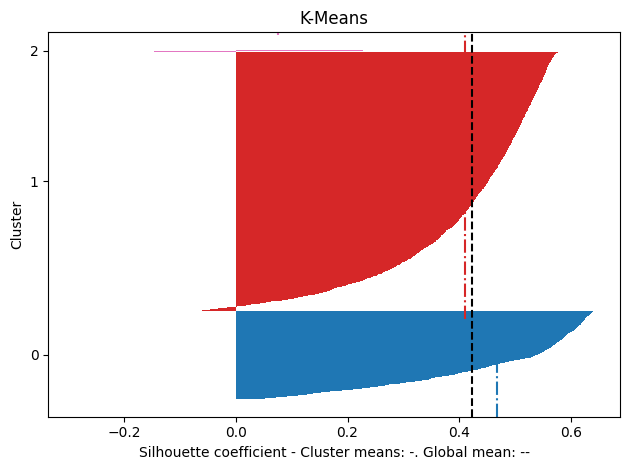

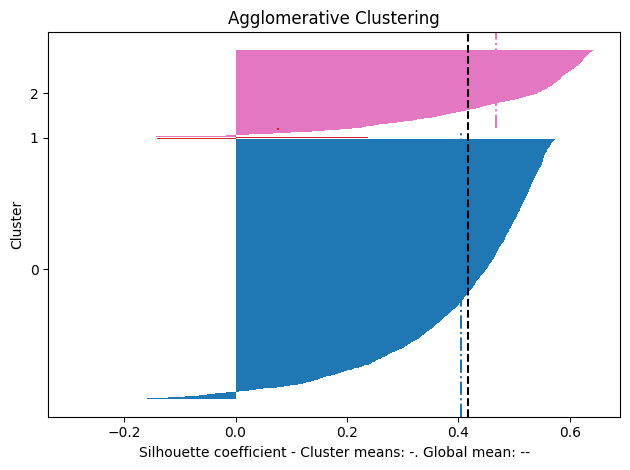

In [48]:
from sklearn.metrics import silhouette_samples

plt.title('K-Means')
plot_silhouette(silhouette_samples(
    scaled_df, customer_df['cluster_km']), customer_df['cluster_km'])
plt.show()

plt.title('Agglomerative Clustering')
plot_silhouette(silhouette_samples(
    scaled_df, customer_df['cluster_ac']), customer_df['cluster_ac'])
plt.show()

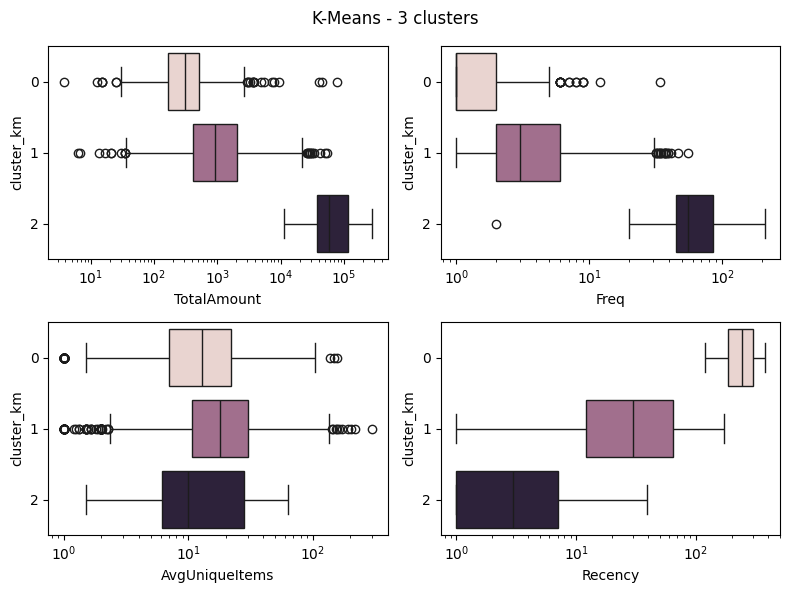

In [49]:
plt.figure(figsize=(8, 6))
plt.suptitle('K-Means - 3 clusters')
for idx, col in enumerate(customer_df.columns[:4]):
    plt.subplot(2, 2, idx+1)
    sns.boxplot(y='cluster_km', x=col,
                data=customer_df, hue='cluster_km', orient='h', log_scale=True, legend=False)
    plt.tight_layout()
plt.show()

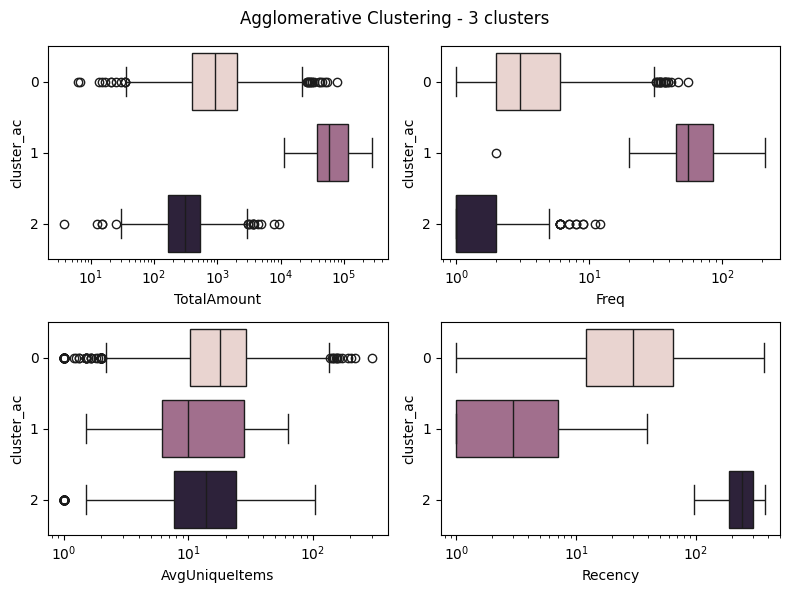

In [50]:
plt.figure(figsize=(8, 6))
plt.suptitle('Agglomerative Clustering - 3 clusters')
for idx, col in enumerate(customer_df.columns[:4]):
    plt.subplot(2, 2, idx+1)
    sns.boxplot(y='cluster_ac', x=col,
                data=customer_df, hue='cluster_ac', orient='h', log_scale=True, legend=False)
    plt.tight_layout()
plt.show()

In [51]:
customer_df.drop(columns='cluster_ac').groupby('cluster_km').mean()

,TotalAmount,Freq,AvgUniqueItems,Recency
cluster_km,,,,
0,613.073192,1.581967,17.238948,245.021858
1,1863.104067,4.677138,23.932530,41.171384
2,86346.543434,68.240000,17.175050,6.120000


In [52]:
customer_df.drop(columns='cluster_km').groupby('cluster_ac').mean()

,TotalAmount,Freq,AvgUniqueItems,Recency
cluster_ac,,,,
0,1903.831400,4.673577,23.465264,42.066213
1,86346.543434,68.240000,17.175050,6.120000
2,471.647418,1.543941,18.530729,245.552266


# Conclusions

The two clustering models provide very similar results. Both models identify more or less the same clusters, with the exception of a few elements.

Let's break down the characteristics of each cluster:

### Cluster 0:
- **TotalAmount:** The average total amount is relatively moderate, around 1903.83.
- **Freq (Frequency):** Customers in this cluster make an average of about 4.67 transactions.
- **AvgUniqueItems (Average Unique Items):** On average, customers purchase around 23.47 unique items.
- **Recency:** The average recency is approximately 42.07.

### Cluster 1:
- **TotalAmount:** This cluster has significantly higher average total spending, around 86346.54.
- **Freq (Frequency):** Customers in this cluster are frequent shoppers, with an average of 68.24 transactions.
- **AvgUniqueItems (Average Unique Items):** Despite high frequency, the average unique items purchased per transaction are around 17.18.
- **Recency:** The average recency is relatively low, approximately 6.12.

### Cluster 2:
- **TotalAmount:** The average total spending is relatively low, around 471.65.
- **Freq (Frequency):** Customers in this cluster make fewer transactions, with an average of 1.54.
- **AvgUniqueItems (Average Unique Items):** On average, customers purchase around 18.53 unique items.
- **Recency:** The average recency is relatively high, approximately 245.55.

### Conclusion:
- **Cluster 0:** Moderate spenders who make a moderate number of transactions, purchasing a diverse range of items, with a moderate recency.
  
- **Cluster 1:** High-value customers who shop frequently, with a high total spending, purchasing a relatively smaller number of unique items, and recent shoppers.

- **Cluster 2:** Low spenders with low transaction frequency, buying a moderate number of unique items, and not very recent shoppers.

In summary, the clustering reveals distinct customer segments with varying spending habits, transaction frequency, and recency. Cluster 1 stands out as a high-value segment, while Cluster 2 represents low-value, less frequent customers. Cluster 0 falls in between with moderate characteristics.

Same results with Agglomerative Clustering but with a different order of the clusters.

---

### 5 Clusters

In [53]:
CLUSTERS = 5
num = CLUSTERS - 2

estimators_kmeans[num]

KMeans(n_clusters=5, n_init=50, random_state=1234)

In [54]:
print(
    f"Number of clusters = {estimators_kmeans[num].n_clusters} - Distortion = {inertias[num]:.2f} - Silhouette score = {silhouette_scores[num]:.2f}")

Number of clusters = 5 - Distortion = 4549.73 - Silhouette score = 0.48


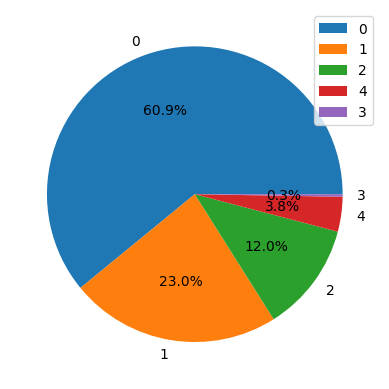

In [55]:
label_series = pd.Series(labels_kmeans[num])

plt.pie(label_series.value_counts(), autopct='%1.1f%%',
        labels=label_series.value_counts().index.tolist())
plt.legend(label_series.value_counts().index.tolist())
plt.show()

As we can see now there is still a big cluster with 4 smaller clusters (one representing only the 0.3% of the data set). Probably the 0.3% cluster is a subset of the 0.6% cluster from the 3 clusters solution.

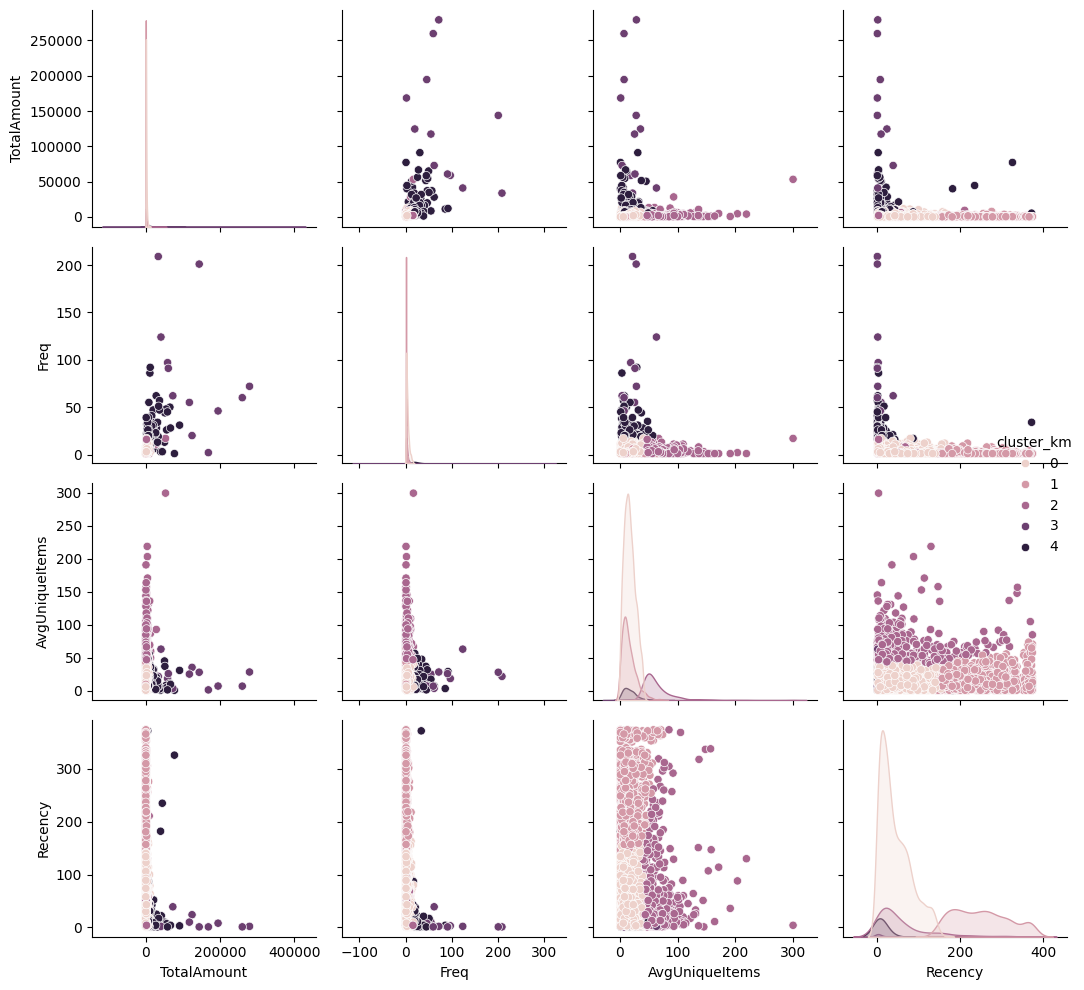

In [57]:
customer_df['cluster_km'] = labels_kmeans[num]
sns.pairplot(customer_df.drop(columns='cluster_ac'), hue='cluster_km')
plt.tight_layout()
plt.show()

The outliers are the customers with the highest amount spent, high frequency and low recency.

# Agglomerative Clustering

We can also try the Agglomerative Clustering algorithm. We will use the same number of clusters as in the K-Means algorithm. 
Keep in mind that the Agglomerative Clustering algorithm makes use of a distance matrix by means of the linkage function. We will use the Ward linkage function which minimizes the variance of the clusters being merged.

In [58]:
from sklearn.cluster import AgglomerativeClustering

In [60]:
estimators_agg = []
labels_agg = []
agg_df = pd.DataFrame(columns=['linkage', 'n_clusters', 'silhouette_score'])
i = 0

for k in np.arange(2, 6):
    for link in ['ward', 'complete', 'single', 'average']:
        est = AgglomerativeClustering(n_clusters=k, linkage=link)
        est.fit(X)
        labels = est.fit_predict(X)
        estimators_agg.append(est)
        labels_agg.append(labels)
        sh_score = silhouette_score(
            X, labels=est.labels_, random_state=1234)
        agg_df.loc[i] = [link, k, sh_score]
        i += 1

We sort the clusters by the silhouette score and select the number of clusters with the highest score still using 5 clusters as in the K-Means algorithm.

In [62]:
agg_df[agg_df.n_clusters >= 5].sort_values(by='silhouette_score', ascending=False).head()

,linkage,n_clusters,silhouette_score
14,single,5,0.868417
15,average,5,0.808404
13,complete,5,0.636556
12,ward,5,0.382179


In [65]:
agg_df[(agg_df.linkage == 'ward')]

,linkage,n_clusters,silhouette_score
0,ward,2,0.854945
4,ward,3,0.430855
8,ward,4,0.380942
12,ward,5,0.382179


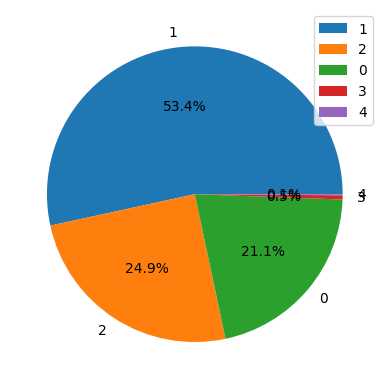

In [64]:
label_series = pd.Series(labels_agg[12])

plt.pie(label_series.value_counts(), autopct='%1.1f%%',
        labels=label_series.value_counts().index.tolist())
plt.legend(label_series.value_counts().index.tolist())
plt.show()

Cluster 4 and 5 are almost overlapping. This may indicate that the number of clusters is too high and we should use less clusters.

What about 4 clusters?

In [67]:
agg_df[(agg_df.linkage == 'ward')]

,linkage,n_clusters,silhouette_score
0,ward,2,0.854945
4,ward,3,0.430855
8,ward,4,0.380942
12,ward,5,0.382179


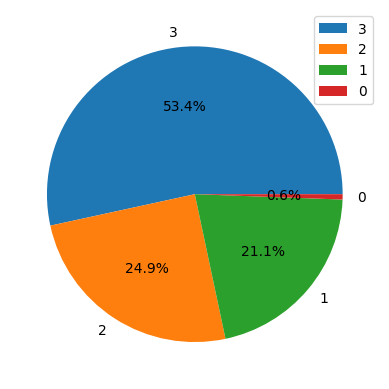

In [68]:
label_series = pd.Series(labels_agg[8])

plt.pie(label_series.value_counts(), autopct='%1.1f%%',
        labels=label_series.value_counts().index.tolist())
plt.legend(label_series.value_counts().index.tolist())
plt.show()

Also with 4 clusters we have always the 0.6% cluster. So ineed it is an outlier and it should be removed from the data set.

We can also keep it but we should use 3 clusters instead of 4.

Almost the same results as in the K-Means algorithm. Cluster 1 has the highest amount spent, high frequency and low recency.

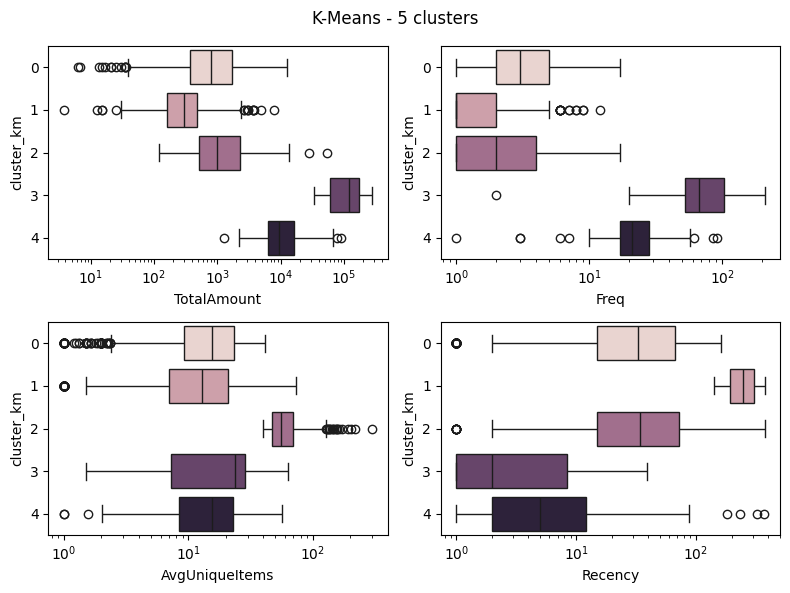

In [71]:
plt.figure(figsize=(8, 6))
plt.suptitle('K-Means - 5 clusters')
for idx, col in enumerate(customer_df.columns[:4]):
    plt.subplot(2, 2, idx+1)
    sns.boxplot(y='cluster_km', x=col,
                data=customer_df, hue='cluster_km', orient='h', log_scale=True, legend=False)
    plt.tight_layout()
plt.show()

In [74]:
customer_df.drop(columns='cluster_ac').groupby('cluster_km').mean()

,TotalAmount,Freq,AvgUniqueItems,Recency
cluster_km,,,,
0,1309.973557,3.908437,16.917873,44.415437
1,431.532240,1.534535,15.555297,250.910911
2,1862.363421,3.119461,63.585722,59.302505
3,129564.244999,86.583333,22.332854,7.750000
4,14587.873650,23.993939,16.837350,15.951515


### Cluster 0:
- **TotalAmount:** The average total amount spent is around 1309.97.
- **Freq (Frequency):** Customers in this cluster make an average of about 3.91 transactions.
- **AvgUniqueItems (Average Unique Items):** On average, customers purchase around 16.92 unique items.
- **Recency:** The average recency is approximately 44.42.

### Cluster 1:
- **TotalAmount:** The average total spending is relatively low, around 431.53.
- **Freq (Frequency):** Customers in this cluster make fewer transactions, with an average of 1.53.
- **AvgUniqueItems (Average Unique Items):** On average, customers purchase around 15.56 unique items.
- **Recency:** The average recency is relatively high, approximately 250.91.

### Cluster 2:
- **TotalAmount:** The average total spending is around 1862.36.
- **Freq (Frequency):** Customers in this cluster make an average of about 3.12 transactions.
- **AvgUniqueItems (Average Unique Items):** On average, customers purchase a significantly higher number of unique items, around 63.59.
- **Recency:** The average recency is approximately 59.30.

### Cluster 3:
- **TotalAmount:** This cluster has significantly higher average total spending, around 129564.24.
- **Freq (Frequency):** Customers in this cluster are very frequent shoppers, with an average of 86.58 transactions.
- **AvgUniqueItems (Average Unique Items):** Despite high frequency, the average unique items purchased per transaction are around 22.33.
- **Recency:** The average recency is relatively low, approximately 7.75.

### Cluster 4:
- **TotalAmount:** The average total spending is around 14587.87.
- **Freq (Frequency):** Customers in this cluster make a moderate number of transactions, with an average of about 23.99.
- **AvgUniqueItems (Average Unique Items):** On average, customers purchase around 16.84 unique items.
- **Recency:** The average recency is approximately 15.95.

### Conclusion:
- **Cluster 0:** Moderate spenders who make a moderate number of transactions, purchasing a moderate number of unique items, with a moderate recency.
  
- **Cluster 1:** Low spenders with low transaction frequency, buying a moderate number of unique items, and not very recent shoppers.

- **Cluster 2:** Moderate spenders who make a moderate number of transactions, but stand out for purchasing a significantly higher number of unique items, with a moderate recency.

- **Cluster 3:** High-value customers who shop very frequently, with a high total spending, purchasing a relatively higher number of unique items, and recent shoppers.

- **Cluster 4:** Customers with moderate total spending, a moderate number of transactions, purchasing a moderate number of unique items, and recent shoppers.

In summary, the clustering reveals distinct customer segments with varying spending habits, transaction frequency, and recency. Cluster 3 stands out as a high-value segment with very frequent shoppers, while other clusters represent different combinations of spending and shopping behavior.

---

As an exercise, you can try different clustering algorithms like DBSCAN for example and see if the results improve.